In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings 
import pandas as pd


warnings.filterwarnings("ignore")

In [2]:
regions = gpd.GeoDataFrame.from_file(
    "../data/POA_2021_AUST_GDA2020_SHP/POA_2021_AUST_GDA2020.shp"
)

In [3]:
regions = regions[regions["geometry"] != None]
regions['postcode'] = regions['POA_CODE21'].astype(int)

<AxesSubplot:>

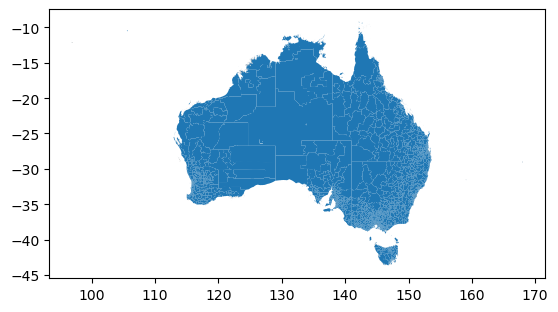

In [4]:
regions.plot()

In [5]:
trans_df = pd.concat([
    pd.read_parquet("../data/tables/transactions_20210228_20210827_snapshot/20210228_20210827.parquet"),
    pd.read_parquet("../data/tables/transactions_20210828_20220227_snapshot/20210828_20220227.parquet")])

In [6]:
trans_df = pd.merge(
    trans_df,
    pd.read_parquet("../data/tables/consumer_user_details.parquet"),
    on="user_id"
)

In [7]:
consumer_df = pd.read_csv("../data/tables/tbl_consumer.csv",sep="|")

In [8]:
con_postcode_count = consumer_df.groupby("postcode")["name"].count().reset_index().rename(columns={"name":"count"})

In [9]:
trans_df

,user_id,merchant_abn,dollar_value,date,consumer_id
0,18482,89295426212,132.460994,2021-08-12,918448
1,18482,79417999332,70.263014,2021-08-23,918448
2,18482,86662713230,73.528056,2021-08-23,918448
3,18482,31322181845,11.596960,2021-08-23,918448
4,18482,26169574842,457.146927,2021-08-23,918448
...,...,...,...,...,...
8151367,8703,49505931725,67.207462,2022-01-22,903063
8151368,8703,41705715409,18.161870,2022-01-25,903063
8151369,8703,86578477987,31.887646,2022-01-25,903063
8151370,8703,24852446429,24.965486,2022-01-25,903063


In [10]:
trans_postcode_count = pd.merge(
    trans_df.groupby("consumer_id")["user_id"].count().reset_index().rename(columns={"user_id":"count"}),
    consumer_df[["consumer_id","postcode"]],
    on="consumer_id"
).groupby("postcode")["count"].sum().reset_index()

<AxesSubplot:>

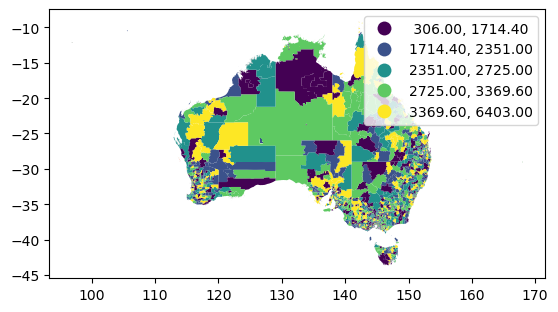

In [11]:
pd.merge(
    regions[['postcode','geometry']],
    trans_postcode_count,
    on="postcode"
).plot(
    column = 'count',
    scheme = 'quantiles',
    legend = True
)

In [12]:
trans_postcode_count

,postcode,count
0,200,1347
1,800,3777
2,801,2718
3,804,2403
4,810,3343
...,...,...
3160,9013,2702
3161,9015,2326
3162,9464,3036
3163,9726,2026


In [2]:
import folium
tip_proportion = folium.Map(location=[40.66, -74.1], tiles="Stamen Terrain", zoom_start=10, control = True)

tip_proportion.add_child(folium.Choropleth(geo_data=regions, data = trans_postcode_count, 
                                            columns = ['postcode', 'count'],
                                            key_on = 'properties.postcode',
                                            fill_color = 'OrRd', name='choropleth'))